In [1]:
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

import pprint
pp = pprint.PrettyPrinter(indent=4)

# Autocast

```
question = {
  'id',                unique identifier (str)
  'question',          question body (str)
  'background',        question context/details (str)
  'qtype',             question type (str)
  'status',            question status (str)
  'choices',           choices or possible ranges (List or Dict)
  'answer',            question resolution (str or float)
  'crowd',             human crowd forecasts over time (List)
  'publish_time',      publish timestamp (str)
  'close_time',        close timestamp (str)
  'prediction_count',  number of crowd predictions (int)
  'forecaster_count',  number of crowd forecasters (int)
  'tags',              question category (List)
  'source_links',      source links from comments (List)
}
```

In [2]:
questions = json.load(open('data/autocast_questions.json')) # Download from GitHub
qid_to_question = {q['id']: q for q in questions}

In [3]:
def get_question_splits(questions):
    resolved_train, unresolved_train, resolved_test, unresolved_test = 0,0,0,0
    for q in questions:
        if q['status'] == 'Resolved':
            if q['close_time'] < '2021-05-11':
                resolved_train += 1
            else:
                resolved_test += 1
        else:
            if q['publish_time'] < '2021-05-11':
                unresolved_train += 1
            else:
                unresolved_test += 1
    return resolved_train, resolved_test, unresolved_train, unresolved_test

print(get_question_splits(questions))
print('TOTAL', len(questions))

(2797, 951, 1164, 1620)
TOTAL 6532


We can add negated T/F questions to balance the dataset.

In [14]:
negations = json.load(open('data/negated_tf_questions.json')) # Download from GitHub
qid_to_negation = {q['id']: q for q in negations}

balanced_questions = []
for q in questions:
    if q['qtype'] == 't/f':
        assert q['question'] == qid_to_negation[q['id']]['original']
        negated_q = copy.deepcopy(q)
        negated_q['question'] = qid_to_negation[q['id']]['negated']
        for t in negated_q['crowd']:
            t['forecast'] = 1 - t['forecast'] # flip the forecast probabilities
        if q['answer'] is not None: # flip the resolution
            if q['answer'] == 'yes':
                negated_q['answer'] = 'no'
            else:
                negated_q['answer'] = 'yes'
        balanced_questions.append(negated_q)
    balanced_questions.append(q)

print(get_question_splits(balanced_questions))
print('TOTAL', len(balanced_questions))

(4387, 1364, 1679, 2327)
TOTAL 9757


## Sample True and False Question (T/F)

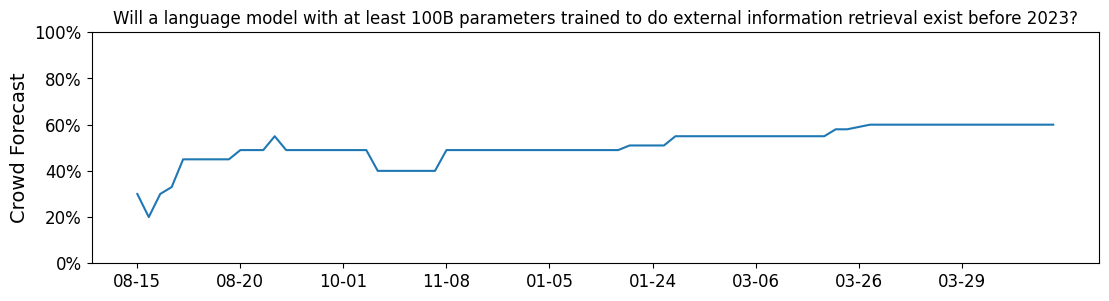

In [15]:
question = qid_to_question['M4876'] # question 4876 on Mataculus (https://www.metaculus.com/questions/4876)

timestamps = []
forecasts = []
for t in question['crowd']:
    timestamps.append(t['timestamp'])
    forecasts.append(t['forecast'] * 100)

plt.figure(figsize=(13, 3))
plt.plot(timestamps, forecasts)
plt.title(question['question'])
plt.xticks(range(len(timestamps)), [d[5:10] for d in timestamps], rotation=0, fontsize=12)
plt.locator_params(axis='x', nbins=10)
plt.ylim(0,100)
plt.ylabel('Crowd Forecast', fontsize=14)
plt.yticks(range(0, 120, 20), [f"{i}%" for i in range(0, 120, 20)], fontsize=12)
plt.show()

The same True and False question but negated. Note that we flip the crowd forecasts.

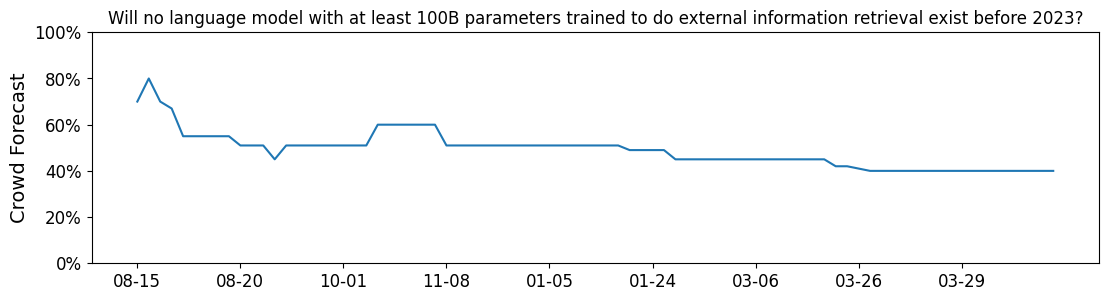

In [31]:
negated_question = qid_to_negation['M4876']

plt.figure(figsize=(13, 3))
plt.plot(timestamps, [100 - f for f in forecasts]) # flip crowd forecasts
plt.title(negated_question['negated'])
plt.xticks(range(len(timestamps)), [d[5:10] for d in timestamps], rotation=0, fontsize=12)
plt.locator_params(axis='x', nbins=10)
plt.ylim(0,100)
plt.ylabel('Crowd Forecast', fontsize=14)
plt.yticks(range(0, 120, 20), [f"{i}%" for i in range(0, 120, 20)], fontsize=12)
plt.show()

## Sample Multiple Choice Question (MCQ)

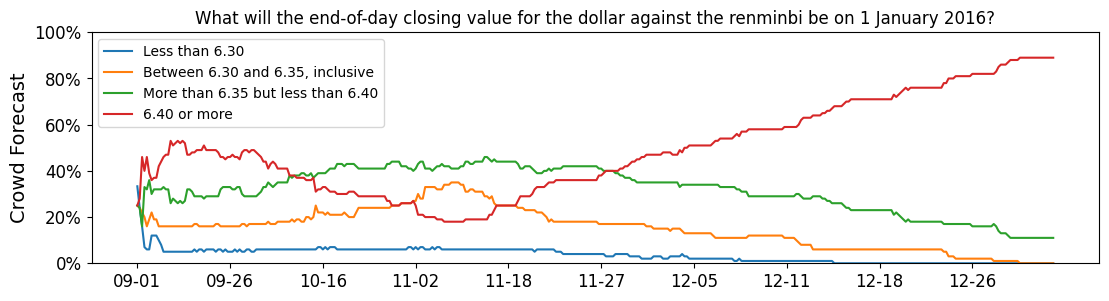

In [32]:
question = qid_to_question['G1']

timestamps = []
forecasts = []
for t in question['crowd']:
    timestamps.append(t['timestamp'])
    forecasts.append(t['forecast'])
forecasts = np.array(forecasts) * 100

plt.figure(figsize=(13, 3))
for c in range(forecasts.shape[1]):
    plt.plot(timestamps, forecasts[:, c], label=question['choices'][c])
plt.title(question['question'])
plt.xticks(range(len(timestamps)), [d[5:10] for d in timestamps], rotation=0, fontsize=12)
plt.locator_params(axis='x', nbins=10)
plt.ylim(0,100)
plt.ylabel('Crowd Forecast', fontsize=14)
plt.yticks(range(0, 120, 20), [f"{i}%" for i in range(0, 120, 20)], fontsize=12)
plt.legend()
plt.show()

## Sample Numerical Question (Numerical)

All numerical questions are (log) normalized to `[0,1]` based on max/min/deriv_ratio stats in `question['choices']`. The following functions denormalize the point.

In [33]:
# The following functions are adapted from https://github.com/oughtinc/ergo

def date_to_timestamp(date):
    dt = datetime.strptime(date, "%Y-%m-%d")
    return dt

def denormalize_point(point, choices):
    """
    Log scale denormalization.
    """
    if point is None:
        raise Exception("Point was None This shouldn't happen")
    
    deriv_term = (choices['deriv_ratio'] ** point - 1) / (choices['deriv_ratio'] - 1)

    if type(choices['max']) == str:
        max_val, min_val = date_to_timestamp(choices['max']), date_to_timestamp(choices['min'])
        scaled = (max_val - min_val).total_seconds() * deriv_term
        scaled = timedelta(seconds=scaled)
    else:
        max_val, min_val = choices['max'], choices['min']
        scaled = (max_val - min_val) * deriv_term
    
    return min_val + scaled

The following question forecasts a numerical quantity.

normalization stats: {'max': 500000, 'min': 1, 'deriv_ratio': 500000}


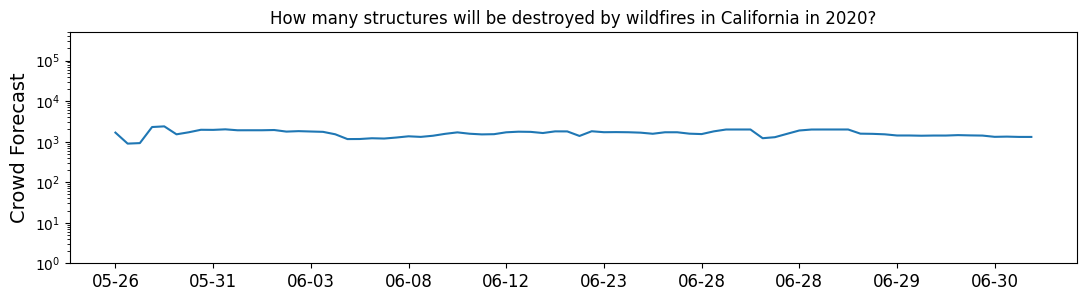

In [68]:
question = qid_to_question['M4446']

print('normalization stats:', question['choices'])

timestamps = []
forecasts = []
for t in question['crowd']:
    timestamps.append(t['timestamp'])
    forecasts.append(denormalize_point(t['forecast'], question['choices'])) # denormalize

plt.figure(figsize=(13, 3))
plt.plot(timestamps, forecasts)
plt.title(question['question'])
plt.xticks(range(len(timestamps)), [d[5:10] for d in timestamps], rotation=0, fontsize=12)
plt.locator_params(axis='x', nbins=10)
plt.ylim(question['choices']['min'], question['choices']['max'])
plt.ylabel('Crowd Forecast', fontsize=14)
plt.yscale('log')
plt.show()

The following question forecasts a date.

normalization stats: {'max': '2022-01-01', 'min': '2021-05-28', 'deriv_ratio': 35.421052631578945}


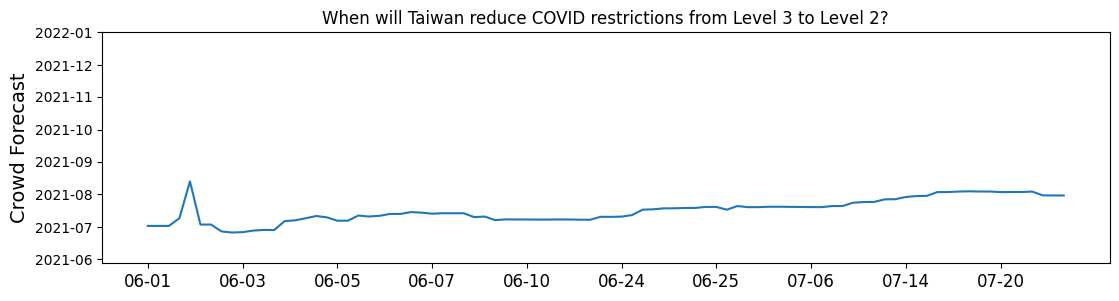

In [69]:
question = qid_to_question['M7241']

print('normalization stats:', question['choices'])

timestamps = []
forecasts = []
for t in question['crowd']:
    timestamps.append(t['timestamp'])
    forecasts.append(denormalize_point(t['forecast'], question['choices'])) # denormalize

low, high = date_to_timestamp(question['choices']['min']), date_to_timestamp(question['choices']['max'])
plt.figure(figsize=(13, 3))
plt.plot(timestamps, forecasts) # for plotting purposes

plt.title(question['question'])
plt.xticks(range(len(timestamps)), [d[5:10] for d in timestamps], rotation=0, fontsize=12)
plt.locator_params(axis='x', nbins=10)
plt.ylim(low, high)
plt.ylabel('Crowd Forecast', fontsize=14)
plt.show()

# cc_news

In [1]:
# https://huggingface.co/docs/datasets/index
from datasets import Dataset

In [11]:
cc_news = Dataset.load_from_disk('data/cc_news') # load from the cc_news directory after decompressing
cc_news.column_names

['title',
 'text',
 'domain',
 'date',
 'description',
 'url',
 'image_url',
 'time',
 '__index_level_0__']

Note: cc_news date/time doesn't contain timezone information. Special cares must be taken to ensure no information leakage.